In [0]:
# ! pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamdiazhari","key":"327b3081f0511c196ce37f1defdcf197"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
import zipfile

! kaggle datasets download -d 'andrewmvd/ocular-disease-recognition-odir5k' -p '/content/sample_data'

local_zip = '/content/sample_data/ocular-disease-recognition-odir5k.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data')
zip_ref.close()

100% 1.25G/1.26G [00:30<00:00, 19.8MB/s]
100% 1.26G/1.26G [00:30<00:00, 44.4MB/s]


In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers

import os
import shutil
from random import sample

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


In [0]:
os.chdir('/content/sample_data/ODIR-5K')

In [7]:
from pandas import read_excel

my_sheet = 'Sheet1'
file_name = '/content/sample_data/ODIR-5K/data.xlsx'
df = read_excel(file_name, sheet_name = my_sheet)
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  ...  C  A  H  M  O
0   0           69      Female  0_left.jpg  0_right.jpg  ...  1  0  0  0  0
1   1           57        Male  1_left.jpg  1_right.jpg  ...  0  0  0  0  0
2   2           42        Male  2_left.jpg  2_right.jpg  ...  0  0  0  0  1
3   3           66        Male  3_left.jpg  3_right.jpg  ...  0  0  0  0  1
4   4           53        Male  4_left.jpg  4_right.jpg  ...  0  0  0  0  1

[5 rows x 15 columns]


In [0]:
leftEyeKeywords = df['Left-Diagnostic Keywords'].copy()
rightEyeKeywords = df['Right-Diagnostic Keywords'].copy()

In [0]:
leftEyeKeywords = leftEyeKeywords.str.split("，")
rightEyeKeywords = rightEyeKeywords.str.split("，")

In [10]:
leftEyeKeywords[2]

['laser spot', 'moderate non proliferative retinopathy']

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(rightEyeKeywords),
                   columns=mlb.classes_,
                   index=rightEyeKeywords.index)

allDiagnosisLeft = res.columns.to_list()
len(allDiagnosisLeft)

res = pd.DataFrame(mlb.fit_transform(leftEyeKeywords),
                   columns=mlb.classes_,
                   index=leftEyeKeywords.index)

allDiagnosisRight = res.columns.to_list()
len(allDiagnosisRight)

allDiagnosis=list(set(allDiagnosisLeft+allDiagnosisRight))
print("total different keys diagnosis :", len(allDiagnosis))

total different keys diagnosis : 105


In [13]:
test_df = df.copy()
doubleDiagnosisRow = []

def getKeyDiagnosisSingle(colName):
  keyDiagnosis = []
  global doubleDiagnosisRow
  store = True
  for row in range(len(test_df[colName])):
    store = True
    if test_df[colName][row] == 1:
      for lable in test_df.columns[7:]:
        if lable == colName:
          continue
        if test_df[lable][row] == 1:
          doubleDiagnosisRow.append(row)
          store = False
          break
        
      if store == True:
        for i in rightEyeKeywords[row]:
          keyDiagnosis.append(i)
        for i in leftEyeKeywords[row]:
          keyDiagnosis.append(i)
      

  keyDiagnosis = list(set(keyDiagnosis))
  return keyDiagnosis

keyNormal = getKeyDiagnosisSingle(test_df.columns[7])
keyDiabetes = getKeyDiagnosisSingle(test_df.columns[8])
keyGlaucoma = getKeyDiagnosisSingle(test_df.columns[9])
keyCataract = getKeyDiagnosisSingle(test_df.columns[10])
keyAMD = getKeyDiagnosisSingle(test_df.columns[11])
keyHypertension = getKeyDiagnosisSingle(test_df.columns[12])
keyMyopia = getKeyDiagnosisSingle(test_df.columns[13])
keyOtherDisease = getKeyDiagnosisSingle(test_df.columns[14])

labelString = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']
keyAll = [keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

keyNormal

Normal 3
Diabetes 10
Glaucoma 5
Cataract 3
AMD 3
Hypertension 1
Myopia 6
Abnormalities 57


['low image quality', 'normal fundus', 'lens dust']

In [14]:
print("intersect by normal :\n")
for i in range(1,len(keyAll)):
  keyAll[i] = list(set(keyAll[i])-set(keyAll[0]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nintersect by other :\n")
for i in range(len(keyAll)):
  for j in range(i,len(keyAll)):
    if i == j:
      continue
    else :
      keyAll[i] = list(set(keyAll[i])-set(keyAll[j]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))

intersect by normal :

Normal 3
Diabetes 8
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54

intersect by other :

Normal 3
Diabetes 7
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54


In [0]:
def getAllRecognizedKey(mkeyAll):
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i]))
  return mallkeyDiagnosis

In [16]:
keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

allkeyDiagnosis = getAllRecognizedKey(keyAll)
len(allkeyDiagnosis)

75

In [17]:
doubleDiagnosisRow = list(set(doubleDiagnosisRow))
print("double lablel row ",len(doubleDiagnosisRow))
doubleDiagnosisRow.sort()
# doubleDiagnosisRow

double lablel row  586


In [18]:
notlisted = []
listed = False
for row in doubleDiagnosisRow:
  # print(row)
  for ilist in leftEyeKeywords[row]:
    # print(ilist)
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

for row in doubleDiagnosisRow:
  for ilist in rightEyeKeywords[row]:
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

notlisted = list(set(notlisted))
# notlisted
print("not listed diagnosis key :",len(notlisted))

not listed diagnosis key : 30


In [0]:
def intersectFromMultiLabel(mkeyAll):
  mnotRecognizedList = []
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i])) 
  for row in doubleDiagnosisRow:
    notlistedList = []
    listedList = []
    colIndex = []
    ind = []
    tempList = []
    for ilist in leftEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)
    for ilist in rightEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)

    for i in range(7, len(test_df.columns)):
      if test_df[test_df.columns[i]][row] == 1:
        colIndex.append(i-7)
    tempList = list(set(tempList))
    isContainAbnormal = 7 in colIndex
    if len(tempList) > 0:
      ind = colIndex
      for ilist in leftEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      for ilist in rightEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      
      for ilist in listedList:
        for i in colIndex:    
          if ilist in keyNormal:
            continue
          if ilist in mkeyAll[i]:
            ind.remove(i)

      if len(ind) == 0 and isContainAbnormal:
        ind.append(7)
      if len(ind) == 1 and len(tempList) == 1:
        mkeyAll[ind[0]] = mkeyAll[ind[0]] + tempList
        mkeyAll[ind[0]] = list(set(mkeyAll[ind[0]]))
      else:
        print("not recognize")
        mnotRecognizedList.append(tempList[0])
        mnotRecognizedList = list(set(mnotRecognizedList))

    mallkeyDiagnosis = []
    for i in mkeyAll:
      mallkeyDiagnosis = mallkeyDiagnosis+list(set(i))
  return mkeyAll, mnotRecognizedList

In [21]:
itterate = True
notRecognizedList = []
while itterate :
  temp_allkeyDiagnosis = allkeyDiagnosis.copy()
  keyAll, notRecognizedList = intersectFromMultiLabel(keyAll)
  allkeyDiagnosis = getAllRecognizedKey(keyAll)
  # print(len(temp_allkeyDiagnosis), len(allkeyDiagnosis))
  print(notRecognizedList)
  if len(temp_allkeyDiagnosis) == len(allkeyDiagnosis):
    print(True)
    itterate = False

not recognize
not recognize
['image offset', 'suspected cataract']
not recognize
not recognize
['image offset', 'suspected cataract']
True


In [22]:
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nall regnized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))

Normal 3
Diabetes 11
Glaucoma 3
Cataract 1
AMD 3
Hypertension 1
Myopia 5
Abnormalities 76

all regnized key : 103

not recognized key :  ['image offset', 'suspected cataract']


In [0]:
#manual listed key
string = 'suspected cataract'
if string in notRecognizedList and string not in allkeyDiagnosis:
  keyAll[3].append(string)
  notRecognizedList.remove(string)

In [24]:
keyAll[3]

['cataract', 'suspected cataract']

In [25]:
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(len(keyAll)):
  print(labelString[i], len(keyAll[i]))

print("\nall regnized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))

Normal 3
Diabetes 11
Glaucoma 3
Cataract 2
AMD 3
Hypertension 1
Myopia 5
Abnormalities 76

all regnized key : 104

not recognized key :  ['image offset']


In [26]:
string = 'central serous chorioretinopathy'

for i in notRecognizedList:
  if i not in allkeyDiagnosis:
    print("not in : ", i)

string in keyOtherDisease

not in :  image offset


True

In [0]:
train_dir = 'training'
validation_dir = 'validation'
test_dir = 'testing'

training_source_path = '/content/sample_data/ODIR-5K/Training Images/'
testing_source_path = '/content/sample_data/ODIR-5K/Testing Images/'

training_path = '/content/sample_data/ODIR-5K/training/'
validation_path = '/content/sample_data/ODIR-5K/validation/'
testing_path = '/content/sample_data/ODIR-5K/testing/'

if os.path.exists(training_path) or os.path.exists(validation_path) or os.path.exists(testing_path):
  shutil.rmtree(training_path)
  shutil.rmtree(validation_path)
  shutil.rmtree(testing_path)

os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

for i in labelString:
  os.mkdir(train_dir+'/'+i)
  os.mkdir(validation_dir+'/'+i)
  os.mkdir(test_dir+'/'+i)

In [28]:
testing_source_files = os.listdir(testing_source_path)
print(len(testing_source_files))
training_source_files = os.listdir(training_source_path)
print(len(training_source_files))

# training_files = training_source_files

fraction = 0.1

nvalidation = int(len(training_source_files)*fraction)
ntraining = len(training_source_files)-nvalidation

validation_files = sample(training_source_files, nvalidation)
training_files = sample(training_source_files, ntraining)
testing_files = testing_source_files
print(len(training_files))
print(len(validation_files))
print(len(testing_files))
# validation_file = testing_source_files


# print(len(validation_files))
# validation_files

1000
7000
6300
700
1000


In [29]:
temp_df = df['Left-Fundus']
len(temp_df)
temp_df[12]
temp_df = df['Right-Fundus']
rightEyeKeywords[5]
testing_files[1]

temp_keywords = rightEyeKeywords
temp_keywords[12]

['retinal pigmentation']

In [30]:
notSortedFiles = []
"using continue because there are files have more than one diagnosis keys"
for fileName in training_files:
  nrow = None
  if 'left' in fileName:
    temp_df = df['Left-Fundus']
    temp_keywords = leftEyeKeywords
  elif 'right' in fileName:
    temp_df = df['Right-Fundus']
    temp_keywords = rightEyeKeywords

  for row in range(len(temp_df)):
    if fileName == temp_df[row]:
      nrow = row
      break

  if nrow == None:
    # print("file not listed in data")
    shutil.copyfile(training_source_path+fileName, training_path+fileName)
    continue

  for i in temp_keywords[nrow]:
    if i in keyNormal:
      shutil.copyfile(training_source_path+fileName, training_path+'Normal/'+fileName)
      continue
    if i in keyDiabetes:
      shutil.copyfile(training_source_path+fileName, training_path+'Diabetes/'+fileName)
      continue
    if i in keyGlaucoma:
      shutil.copyfile(training_source_path+fileName, training_path+'Glaucoma/'+fileName)
      continue
    if i in keyCataract:
      shutil.copyfile(training_source_path+fileName, training_path+'Cataract/'+fileName)
      continue
    if i in keyAMD:
      shutil.copyfile(training_source_path+fileName, training_path+'AMD/'+fileName)
      continue
    if i in keyHypertension:
      shutil.copyfile(training_source_path+fileName, training_path+'Hypertension/'+fileName)
      continue
    if i in keyMyopia:
      shutil.copyfile(training_source_path+fileName, training_path+'Myopia/'+fileName)
      continue
    if i in keyOtherDisease:
      shutil.copyfile(training_source_path+fileName, training_path+'Abnormalities/'+fileName)
      continue
    # else:
    print("not in list key : ", "| row : ", row, "| file name : ", fileName, "| key diagnosis : ", i)
    notSortedFiles.append(fileName)
    notSortedFiles=list(set(notSortedFiles))
    # break
    
print(len(os.listdir('/content/sample_data/ODIR-5K/training/AMD')))
print(len(os.listdir('/content/sample_data/ODIR-5K/training/Abnormalities')))
print(len(os.listdir('/content/sample_data/ODIR-5K/training/Normal')))
print(len(os.listdir('/content/sample_data/ODIR-5K/training/Cataract')))

not in list key :  | row :  1170 | file name :  1243_left.jpg | key diagnosis :  image offset
247
1083
2906
279


In [31]:
for fileName in validation_files:
  nrow = None
  if 'left' in fileName:
    temp_df = df['Left-Fundus']
    temp_keywords = leftEyeKeywords
  elif 'right' in fileName:
    temp_df = df['Right-Fundus']
    temp_keywords = rightEyeKeywords

  for row in range(len(temp_df)):
    if fileName == temp_df[row]:
      nrow = row
      break

  if nrow == None:
    # print("file not listed in data")
    shutil.copyfile(training_source_path+fileName, validation_path+fileName)
    continue

  for i in temp_keywords[nrow]:
    if i in keyNormal:
      shutil.copyfile(training_source_path+fileName, validation_path+'Normal/'+fileName)
      continue
    if i in keyDiabetes:
      shutil.copyfile(training_source_path+fileName, validation_path+'Diabetes/'+fileName)
      continue
    if i in keyGlaucoma:
      shutil.copyfile(training_source_path+fileName, validation_path+'Glaucoma/'+fileName)
      continue
    if i in keyCataract:
      shutil.copyfile(training_source_path+fileName, validation_path+'Cataract/'+fileName)
      continue
    if i in keyAMD:
      shutil.copyfile(training_source_path+fileName, validation_path+'AMD/'+fileName)
      continue
    if i in keyHypertension:
      shutil.copyfile(training_source_path+fileName, validation_path+'Hypertension/'+fileName)
      continue
    if i in keyMyopia:
      shutil.copyfile(training_source_path+fileName, validation_path+'Myopia/'+fileName)
      continue
    if i in keyOtherDisease:
      shutil.copyfile(training_source_path+fileName, validation_path+'Abnormalities/'+fileName)
      continue
    # break
    print("not in list key : ", "| row : ", row, "| file name : ", fileName, "| key diagnosis : ", i)
    notSortedFiles.append(fileName)
    notSortedFiles=list(set(notSortedFiles))

print(len(os.listdir('/content/sample_data/ODIR-5K/validation/AMD')))
print(len(os.listdir('/content/sample_data/ODIR-5K/validation/Abnormalities')))
print(len(os.listdir('/content/sample_data/ODIR-5K/validation/Normal')))
print(len(os.listdir('/content/sample_data/ODIR-5K/validation/Cataract')))

26
119
308
34


In [32]:
for fileName in testing_files:
  nrow = None
  if 'left' in fileName:
    temp_df = df['Left-Fundus']
    temp_keywords = leftEyeKeywords
  if 'right' in fileName:
    temp_df = df['Right-Fundus']
    temp_keywords = rightEyeKeywords

  for row in range(len(temp_df)):
    if fileName == temp_df[row]:
      nrow = row
      break

  if nrow == None:
    # print("file not listed in data")
    shutil.copyfile(testing_source_path+fileName, testing_path+fileName)
    continue

  for i in temp_keywords[nrow]:
    if i in keyNormal:
      shutil.copyfile(testing_source_path+fileName, testing_path+'Normal/'+fileName)
      continue
    if i in keyDiabetes:
      shutil.copyfile(testing_source_path+fileName, testing_path+'Diabetes/'+fileName)
      continue
    if i in keyGlaucoma:
      shutil.copyfile(testing_source_path+fileName, testing_path+'Glaucoma/'+fileName)
      continue
    if i in keyCataract:
      shutil.copyfile(testing_source_path+fileName, testing_path+'Cataract/'+fileName)
      continue
    if i in keyAMD:
      shutil.copyfile(testing_source_path+fileName, testing_path+'AMD/'+fileName)
      continue
    if i in keyHypertension:
      shutil.copyfile(testing_source_path+fileName, testing_path+'Hypertension/'+fileName)
      continue
    if i in keyMyopia:
      shutil.copyfile(testing_source_path+fileName, testing_path+'Myopia/'+fileName)
      continue
    if i in keyOtherDisease:
      shutil.copyfile(testing_source_path+fileName, testing_path+'Abnormalities/'+fileName)
      continue
    print("not in list key : ", "| row : ", row, "| file name : ", fileName, "| key diagnosis : ", i)
    notSortedFiles.append(fileName)
    notSortedFiles=list(set(notSortedFiles))

print(len(os.listdir('/content/sample_data/ODIR-5K/testing/AMD')))
print(len(os.listdir('/content/sample_data/ODIR-5K/testing/Abnormalities')))
print(len(os.listdir('/content/sample_data/ODIR-5K/testing/Normal')))
print(len(os.listdir('/content/sample_data/ODIR-5K/testing/Cataract')))
print(len(os.listdir('/content/sample_data/ODIR-5K/testing')))

0
0
0
0
1008


In [33]:
notSortedFiles

['1243_left.jpg']

In [34]:
dirList = os.listdir(training_path)
countx = 0
for i in dirList:
  countx+=len(os.listdir(training_path+i))

print(countx)

len(os.listdir(training_source_path))

6868


7000

In [35]:
from PIL import Image

cataractImageList = os.listdir(training_path+'Cataract')
imagePath = training_path+'Cataract/'+cataractImageList[2]
im = Image.open(imagePath)
width, height = im.size
print(width, height, "from", imagePath)

# target_size = (int(height/16),int(width/16))
target_size = (160, 270)

4288 2848 from /content/sample_data/ODIR-5K/training/Cataract/2231_right.jpg


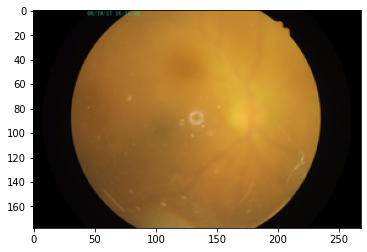

In [36]:
img = image.load_img(imagePath)
plt.imshow(img)
img = image.load_img(imagePath, target_size=target_size, interpolation="lanczos")
plt.imshow(img)

In [37]:
train_datagen = ImageDataGenerator(
                                  rescale = 1./255,
                                  # zoom_range=0.2,
                                  # rotation_range=40,
                                  # horizontal_flip=True,
                                  # width_shift_range=0.2,
                                  # height_shift_range=0.2,
                                  # shear_range=0.2,                                  
                                  fill_mode='nearest',
                                   
                                  # featurewise_center=False,  # set input mean to 0 over the dataset
                                  # samplewise_center=False,  # set each sample mean to 0
                                  # featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                  # samplewise_std_normalization=False,  # divide each input by its std
                                  # zca_whitening=False,  # apply ZCA whitening
                                  # vertical_flip=False
                                  )

validation_datagen = ImageDataGenerator(
                                        rescale = 1./255,
                                        )

train_generator = train_datagen.flow_from_directory(
	training_path,
	target_size=target_size,
  interpolation="lanczos",
  # batch_size=126,
	class_mode='categorical',
  # color_mode='grayscale',
)

validation_generator = validation_datagen.flow_from_directory(
	validation_path,
	target_size=target_size,
  interpolation="lanczos",
  # batch_size=14,
	class_mode='categorical',  
  # color_mode='grayscale',
)

Found 6868 images belonging to 8 classes.
Found 769 images belonging to 8 classes.


In [38]:
nEpoch = 25
input_shape = target_size + (3,)
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
"""
#note:
# adam optimizer fail : not reach local minimum, sometime increase accuracy, sometime decrease

"""
model = tf.keras.models.Sequential([
    # The first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 266, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 133, 64)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 88, 133, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 131, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 65, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 65, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 63, 128)       7

In [39]:
history = model.fit(train_generator, validation_data=validation_generator, 
                    epochs=10,
                    # batch_size=128,
                    steps_per_epoch=50,
                    # verbose=1,
                    # validation_steps = 10,
                    )

Epoch 1/10
50/50 [==============================] - 263s 5s/step - loss: 2.6188 - accuracy: 0.2281 - val_loss: 1.9120 - val_accuracy: 0.3992
Epoch 2/10
50/50 [==============================] - 263s 5s/step - loss: 1.9650 - accuracy: 0.3331 - val_loss: 2.0944 - val_accuracy: 0.1261
Epoch 3/10
50/50 [==============================] - 262s 5s/step - loss: 1.8375 - accuracy: 0.3406 - val_loss: 2.0901 - val_accuracy: 0.3381
Epoch 4/10
50/50 [==============================] - 260s 5s/step - loss: 1.7042 - accuracy: 0.3887 - val_loss: 2.0198 - val_accuracy: 0.4005
Epoch 5/10
50/50 [==============================] - 260s 5s/step - loss: 1.6099 - accuracy: 0.4081 - val_loss: 2.2779 - val_accuracy: 0.1743
Epoch 6/10
50/50 [==============================] - 258s 5s/step - loss: 1.5783 - accuracy: 0.4194 - val_loss: 1.8493 - val_accuracy: 0.3589
Epoch 7/10
50/50 [==============================] - 263s 5s/step - loss: 1.5194 - accuracy: 0.4431 - val_loss: 1.7826 - val_accuracy: 0.3719
Epoch 8/10
50

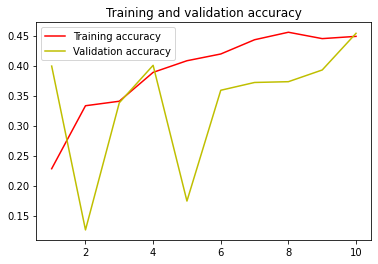

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

file :  /content/sample_data/ODIR-5K/testing/1037_left.jpg
predicted as :  [[0. 0. 0. 0. 0. 0. 1. 0.]]


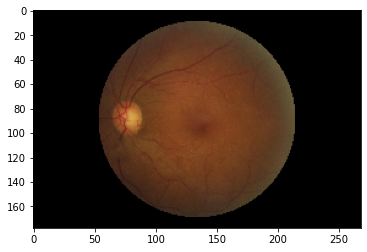

In [43]:
path = '/content/sample_data/ODIR-5K/testing/1037_left.jpg'
img = image.load_img(path, target_size=target_size,)
imgplot = plt.imshow(img)
imgarray = image.img_to_array(img)
imgarray = np.expand_dims(imgarray, axis=0)

images = np.vstack([imgarray])
classes = model.predict(images, batch_size=8)
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# classes = probability_model.predict(images,batch_size=10)
print("file : ", path)
print("predicted as : ", classes)

In [44]:
test_dir = '/content/sample_data/ODIR-5K/testing/'

print(len(os.listdir(test_dir)))

# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=target_size,
#         color_mode="rgb",
#         shuffle = False,
#         class_mode='categorical',
#         batch_size=1)

# filenames = test_generator.filenames
# nb_samples = len(filenames)

# predict = model.predict_generator(test_generator)
# np.argmax(predict[0])
# for i in range (500):
#   print(np.argmax(predict[i]))

1008


In [0]:
# dirList = os.listdir('/content/sample_data/ODIR-5K/testing/')
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# predictions = probability_model.predict(dirList[3])
# dirList